In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import warnings

import yfinance as yf
from pandas_datareader import data as pdr
# import empyrical
# import pyfolio as pf

warnings.filterwarnings("ignore")
yf.pdr_override() 
plt.style.use("fivethirtyeight")

yesterday = datetime.now() - timedelta(1)
yesterday = datetime.strftime(yesterday, '%Y-%m-%d')
today = datetime.strftime(datetime.now(), '%Y-%m-%d')

In [2]:
## FUNCTIONS
def getData(ticker="SPY", start="1994-01-01", end=today, interval='1MO'):
    data = yf.download(tickers=ticker, interval=interval, start=start, end=end)
    data.dropna(axis=0, inplace=True)
    return data.reset_index()

def funcMomentum(data, momentum='simple'):
    data['shift1'] = data['Adj Close'].shift(1)
    data['shift3'] = data['Adj Close'].shift(3)
    data['shift6'] = data['Adj Close'].shift(6)
    data.drop(['Open','High','Low', 'Close', 'Volume'], axis=1, inplace=True)
    data.dropna(axis=0, inplace=True)
    composite = (12*(data['Adj Close']/data['shift1']-1)) + (4*(data['Adj Close']/data['shift3']-1)) + (2*(data['Adj Close']/data['shift6']-1))
    simple = ((data['Adj Close']/data['shift6']-1))
    if momentum == 'composite':
        data['momentum'] = composite # composite weighted  1,3,6 periods return formula
    else:
        data['momentum'] = simple # simple 6 periods return formula
    return data

def acceleratingDualMomentum(interval='1MO', stocks=["spy","scz","tip"], momentum='simple'):
    ## Getting Data
    namespace = globals()
    for i in stocks:
        namespace['%s_data' % str(i)] = getData(ticker=i, end=today, interval=interval)

    ## Creating shift columns and calculating momentum
    for i in stocks:
        namespace['%s_data' % str(i)] = funcMomentum(namespace['%s_data' % str(i)], momentum)
        
    ## series lenght ## hardcoded because ETF release date won't change.
    date = scz_data['Date'] 
    spy_data2 = spy_data.copy()
    spy_data2 = spy_data2.iloc[-len(date):]
    tip_data2 = tip_data.copy()
    tip_data2 = tip_data.iloc[-len(date):]
    
    ## ETF Picking
    etf = []
    ret = [1]
    close = []
    for i in range(0, len(date)):
        if ((spy_data2['momentum'].iloc[i] > scz_data['momentum'].iloc[i]) & (spy_data2['momentum'].iloc[i] > 0)):
            etf.append('SPY')
            ret.append((spy_data2['Adj Close'].iloc[i] / spy_data2['shift1'].iloc[i] - 1))
            close.append(spy_data2['Adj Close'].iloc[i])
        elif ((scz_data['momentum'].iloc[i] > spy_data2['momentum'].iloc[i]) & (scz_data['momentum'].iloc[i] > 0)):
            etf.append('SCZ')
            ret.append((scz_data['Adj Close'].iloc[i] / scz_data['shift1'].iloc[i] - 1))
            close.append(scz_data['Adj Close'].iloc[i])
        else:
            etf.append('TIP')
            ret.append((tip_data2['Adj Close'].iloc[i] / tip_data2['shift1'].iloc[i] - 1))
            close.append(tip_data2['Adj Close'].iloc[i])
   
    ## Returns   
    cumulative_rets = list(np.cumsum(ret))
    ret.pop(0)
    cumulative_rets.pop(0)
    ret_data = {'date':date, 'etf':etf, 'close':close, 'ret':ret, 'Cumulative Returns':cumulative_rets}
    returns = pd.DataFrame(data=ret_data)
    return returns

def sharpeRatio(mean, interest, stdev):
    return (mean - interest) / stdev

def CAGR(last_value, first_value, years):
    return ((last_value/first_value)**(1/years)-1)

In [3]:
monthly = acceleratingDualMomentum(interval='1MO', momentum='composite')
# daily = acceleratingDualMomentum(interval='1D', momentum='simple')#'composite'

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
# print(len(monthly[monthly['ret']<0]))
# monthly[monthly['ret']<0] 
monthly.tail(15)

,date,etf,close,ret,Cumulative Returns
163,2021-08-01 00:00:00-04:00,SPY,443.408295,0.029760,5.411436
164,2021-09-01 00:00:00-04:00,TIP,118.182167,-0.008763,5.402672
165,2021-10-01 00:00:00-04:00,SPY,452.404175,0.073592,5.476264
166,2021-11-01 00:00:00-04:00,SPY,448.769196,-0.008035,5.468229
167,2021-12-01 00:00:00-05:00,SPY,467.880005,0.042585,5.510814
168,2022-01-01 00:00:00-05:00,TIP,119.346542,-0.013141,5.497674
169,2022-02-01 00:00:00-05:00,TIP,119.950165,0.005058,5.502731
170,2022-03-01 00:00:00-05:00,SPY,446.470734,0.034377,5.537108
171,2022-04-01 00:00:00-04:00,TIP,114.791725,-0.026343,5.510765
172,2022-05-01 00:00:00-04:00,TIP,113.499260,-0.011259,5.499506


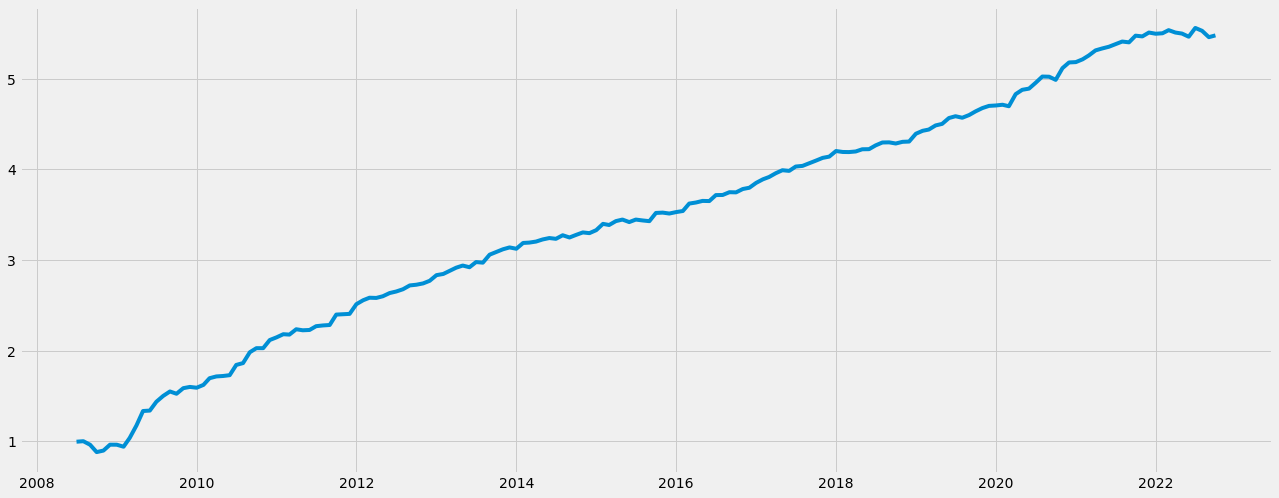

In [5]:
plt.figure(figsize=(20,8))
# plt.plot(weekly['date'], weekly['Cumulative Returns']*100);
# plt.plot(weekly['date'], weekly['ret']);
plt.plot(monthly['date'], monthly['Cumulative Returns']);
# plt.plot(monthly['date'], monthly['ret']);

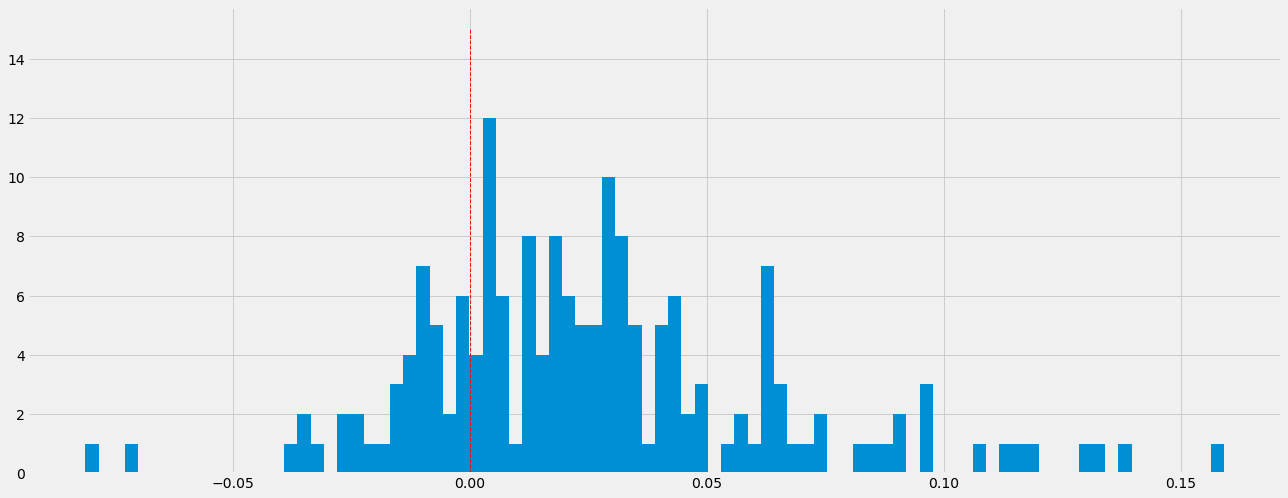

In [32]:
plt.figure(figsize=(20,8))
plt.vlines(0, 0, 15, color='r', linestyle='dashed', linewidth=1)
plt.hist(monthly['ret'], bins=int(len(monthly['ret'])/2));

In [7]:
anos_monthly = len(monthly['ret'])*30/365
anos_weekly = len(monthly['ret'])*7/365
primeiro = monthly['Cumulative Returns'].iloc[0]
ultimo = monthly['Cumulative Returns'].iloc[-1]

total_return = (ultimo - primeiro / primeiro)
annualized_returns = CAGR(ultimo, primeiro, anos_monthly)
annual_std = monthly['ret'].std()

print('Total return: ',total_return*100)
print('Annual return: ', annualized_returns*100) 
print('Annual std: ', annual_std*100,)

Total return:  447.9285317401939
Annual return:  12.826661670253392
Annual std:  3.7913184019557433


In [8]:
interest_rate_source = 'https://fred.stlouisfed.org/data/TB3MS.txt'
interest_rate = float(pd.read_csv(interest_rate_source, sep=' ', skiprows=11).iloc[-1:]['Unnamed: 3'] / 100)
    
sharpeRatio(annualized_returns, interest_rate, annual_std)

2.5575962349275096

#### Ideas
- add Column with initial balance to returns (add an arg to acceleratingDualMomentum(), called initial_balance)
-

#### to-do
- sortino ratio
- max drawdown
- period drawdown

#### done
- annualized return
- sharpe ration

[Annualized Return 1](https://12ft.io/proxy?q=https%3A%2F%2Fpython.plainenglish.io%2Fcalculating-annualized-expected-stock-returns-using-python-aaba430ca8a9)  
[get fred data](https://12ft.io/proxy?q=https%3A%2F%2Fmedium.com%2Fswlh%2Fpandas-datareader-federal-reserve-economic-data-fred-a360c5795013)  
[calculate sharpe ratio](https://12ft.io/proxy?q=https%3A%2F%2Ftowardsdatascience.com%2Fcalculating-sharpe-ratio-with-python-755dcb346805)  
[Sharpe Ratio - CFI](https://corporatefinanceinstitute.com/resources/knowledge/finance/sharpe-ratio-definition-formula/)  
[CAGR - Investopedia](https://www.investopedia.com/terms/a/annualized-total-return.asp#:~:text=An%20annualized%20total%20return%20is,the%20annual%20return%20was%20compounded.)  
[CAGR - Felipe Rego](https://feliperego.github.io/blog/2016/08/10/CAGR-Function-In-Python)  
[]()  

In [9]:
# returns = monthly['ret']
# returns.index = monthly['date']
# empyrical.sharpe_ratio(returns)
# pf.create_simple_tear_sheet(returns, benchmark_rets=None)